#### Imports

In [1]:
import numpy as np
import glob
import torch
from prettytable import PrettyTable
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import Accuracy, F1Score
from tqdm import tqdm

W0703 18:30:34.052000 9660 torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


---
#### Check The Nvidia Graphics is available

In [2]:
!nvidia-smi

Thu Jul  3 17:32:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.52                 Driver Version: 576.52         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   48C    P8              4W /  102W |     498MiB /   8188MiB |     14%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

---
#### Load Dataset

In [2]:
def get_dataset(mode: str):
    data_dir = f'./UCI HAR Dataset/{mode}/Inertial Signals/*.txt'
    x_data = []
    for file in glob.glob(data_dir):
        x_data.append(np.loadtxt(file))

    y_data = np.loadtxt(f'./UCI HAR Dataset/{mode}/y_{mode}.txt')

    x = torch.FloatTensor(np.array(x_data)).permute(1, 2, 0)
    y = torch.LongTensor(y_data) - 1
    return x, y

In [3]:
x_train, y_train = get_dataset('train')

print(x_train.shape, y_train.shape)
print(torch.unique(y_train))  # The -1 in the def is for this line (to class_numbers be from 0 to ...)

torch.Size([7352, 128, 9]) torch.Size([7352])
tensor([0, 1, 2, 3, 4, 5])


In [4]:
x_test, y_test = get_dataset('test')

print(x_test.shape, y_test.shape)
print(torch.unique(y_test))  # The -1 in the def is for this line (to class_numbers be from 0 to ...)

torch.Size([2947, 128, 9]) torch.Size([2947])
tensor([0, 1, 2, 3, 4, 5])


---
#### Tensor Dataset

In [5]:
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

---
#### DataLoader

In [6]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [7]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([128, 128, 9]), torch.Size([128]))

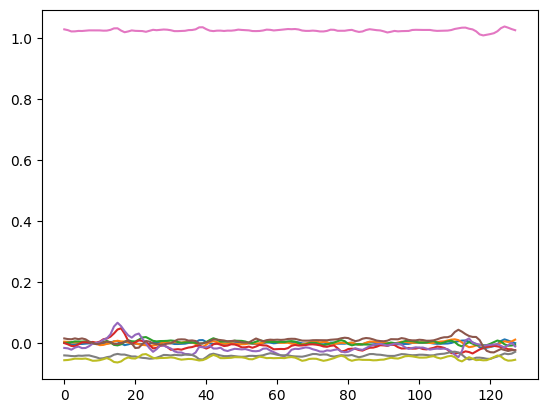

In [8]:
plt.plot(x[0])

---
#### Device

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

---
#### Models

##### RNN

In [76]:
model_name = 'rnn'

In [10]:
class RNNModel(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 bidirectional: bool,
                 num_layers: int,
                 nonlinearity: str,
                 bias: bool,
                 batch_first: bool,
                 dropout: float,
                 classes_numbers: int):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          nonlinearity=nonlinearity,
                          bias=bias,
                          batch_first=batch_first,
                          dropout=dropout,
                          bidirectional=bidirectional)
        # hidden_size = hidden_size * 2 if bidirectional else hidden_size
        # self.fc = nn.Linear(hidden_size, classes_numbers)
        self.fc = nn.LazyLinear(classes_numbers)  # fc: The fully connected Layer,

    def forward(self, x_input):
        outputs, _ = self.rnn(x_input)  # outputs, hidden
        y = self.fc(outputs)
        return y.mean(dim=1)


In [11]:
def define_model():
    """
    Defining the model with this method.
    :return: The model that convert to device (CUDA if accessible and CPU if not)
    """

    rnn_model = RNNModel(input_size=9,
                         hidden_size=128,
                         bidirectional=False,
                         num_layers=3,
                         nonlinearity='tanh',
                         bias=True,
                         batch_first=True,
                         dropout=0.0,
                         classes_numbers=6)

    rnn_model.to(device)
    return rnn_model

##### LSTM

In [95]:
model_name = 'lstm'

In [96]:
class LSTMModel(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 bidirectional: bool,
                 num_layers: int,
                 bias: bool,
                 batch_first: bool,
                 dropout: float,
                 classes_numbers: int):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            bias=bias,
                            batch_first=batch_first,
                            dropout=dropout,
                            bidirectional=bidirectional)
        # hidden_size = hidden_size * 2 if bidirectional else hidden_size
        # self.fc = nn.Linear(hidden_size, classes_numbers)
        self.fc = nn.LazyLinear(classes_numbers)  # fc: The fully connected Layer,

    def forward(self, x_input):
        outputs, _ = self.lstm(x_input)  # outputs, hidden
        y = self.fc(outputs)
        return y.mean(dim=1)

In [97]:
def define_model():
    """
    Defining the model with this method.
    :return: The model that convert to device (CUDA if accessible and CPU if not)
    """

    lstm_model = LSTMModel(input_size=9,
                           hidden_size=128,
                           bidirectional=False,
                           num_layers=3,
                           bias=True,
                           batch_first=True,
                           dropout=0.0,
                           classes_numbers=6)

    lstm_model.to(device)
    return lstm_model

##### Transformer

In [10]:
model_name = 'transformer'

In [11]:
class TransformerModel(nn.Module):
    def __init__(self,
                 d_model,
                 nhead,
                 num_encoder,
                 dropout,
                 activation,
                 batch_first,
                 dim_feedforward,
                 bias,
                 classes_numbers):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model,
                                                   nhead=nhead,
                                                   dim_feedforward=dim_feedforward,
                                                   dropout=dropout,
                                                   activation=activation,
                                                   batch_first=batch_first,
                                                   bias=bias)
        self.encoder = nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=num_encoder)
        self.fc = nn.LazyLinear(classes_numbers)
        self.linear = nn.LazyLinear(d_model)
        self.bn = nn.LazyBatchNorm1d()

    def forward(self, x_input):
        _x = self.bn(self.linear(x_input)).relu()
        return self.fc(self.encoder(_x)[:, -1])

In [12]:
def define_model():
    """
    Defining the model with this method.
    :return: The model that convert to device (CUDA if accessible and CPU if not)
    """
    d_model = 128

    transformer_model = TransformerModel(d_model=d_model,
                                         nhead=8,
                                         num_encoder=8,
                                         dropout=0.1,
                                         activation='relu',
                                         batch_first=True,
                                         dim_feedforward=4 * d_model,
                                         bias=True,
                                         classes_numbers=6)
    transformer_model.to(device)

    return transformer_model

##### Test the model

In [13]:
test_model = define_model()

In [14]:
test_model

TransformerModel(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): LazyLinear(in_features=0, out_features=6, bias=True)
  (linear): LazyLinear(in_features=0, out_features=128, bias=True)
  (bn): LazyBatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [15]:
test_model(x.to(device)).shape

torch.Size([128, 6])

---
#### Loss Function

In [16]:
loss_fn = torch.nn.CrossEntropyLoss()

---
#### AverageMeter

In [17]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

---
#### Methods of train and validate model:

In [18]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch, disable_log=False):
    """
    Train one epoch of your model with this method.
    :param model: The model to be trained.
    :param train_loader: The data loader of the training data.
    :param loss_fn: The loss function.
    :param optimizer: The optimizer.
    :param epoch: The current epoch.
    :param disable_log: Pass it True to disable log while training.
    :return: The trained model of that epoch, the loss of train, the accuracy of train and the f1-score of train
    """

    model.train()
    loss_train = AverageMeter()
    acc_train = Accuracy(task="multiclass", num_classes=6).to(device)
    f1_train = F1Score(task="multiclass", num_classes=6).to(device)

    with tqdm(train_loader, unit='batch', disable=disable_log) as t_loader:
        for data, target in t_loader:
            data = data.to(device)
            target = target.to(device)

            predict = model(data)

            loss = loss_fn(predict, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

            optimizer.step()
            optimizer.zero_grad()

            loss_train.update(loss.item())
            acc_train(predict, target)
            f1_train(predict, target)

            t_loader.set_description(f"Epoch: {epoch}")
            t_loader.set_postfix(loss=loss_train.avg,
                                 accuracy=f"{(acc_train.compute().cpu().item() * 100):.4}%",
                                 f1=f"{(f1_train.compute().cpu().item() * 100):.4}%")

    return model, loss_train.avg, acc_train.compute(), f1_train.compute()

In [19]:
def valid_one_epoch(model, valid_loader, loss_fn):
    """
    Validate one epoch of your model with this method.
    :param model: The model to be validated.
    :param valid_loader: The data loader of the validation data.
    :param loss_fn: The loss function.
    :return: The loss of validation, the accuracy of validation and the f1-score of validation
    """

    model.eval()
    with torch.no_grad():
        loss_valid = AverageMeter()
        acc_valid = Accuracy(task="multiclass", num_classes=6).to(device)
        f1_valid = F1Score(task="multiclass", num_classes=6).to(device)
        for data, target in valid_loader:
            data = data.to(device)
            target = target.to(device)

            predict = model(data)
            loss = loss_fn(predict, target)

            loss_valid.update(loss.item())
            acc_valid(predict, target)
            f1_valid(predict, target)

    return loss_valid.avg, acc_valid.compute(), f1_valid.compute()

---
#### Select best Learning Rate and Weight decay

In [20]:
list_for_table_loss_train = []
list_for_table_acc_train = []
list_weight_decays = ['(⬇️LR) (WD➡️)', 0, 1e-4, 1e-5, 1e-6]

In [ ]:
for_range = 5

for confidence in [1, 0.1, 0.01]:
    for lr in [0.1, 0.15, 0.2, 0.25, 0.3]:
        temp_list_loss_train = [round(lr * confidence, 5)]
        temp_list_acc_train = [round(lr * confidence, 5)]

        for wd in [0., 1e-4, 1e-5, 1e-6]:
            model = define_model()
            optimizer = torch.optim.SGD(model.parameters(),
                                        lr=(lr * confidence),
                                        momentum=0.9,
                                        # nesterov=True,
                                        weight_decay=wd)

            print(f'LR={(lr * confidence):.5}, WD={wd}')
            for epoch in range(for_range):
                model, loss_train, acc_train, _ = train_one_epoch(model=model,
                                                                  train_loader=train_loader,
                                                                  loss_fn=loss_fn,
                                                                  optimizer=optimizer,
                                                                  epoch=epoch,
                                                                  disable_log=False)
                if epoch == (for_range - 1):
                    temp_list_loss_train.append(round(loss_train, 3))
                    temp_list_acc_train.append(f"{(acc_train.item() * 100):.3}%")

        list_for_table_loss_train.append(temp_list_loss_train)
        list_for_table_acc_train.append(temp_list_acc_train)

#### Show tabular data

In [60]:
def show_tabular_data(field_names, rows):
    """
    Show data tabular with PrettyTable.
    :param field_names: The names of header of the table.
    :param rows: The data rows.
    :return: None (Print the table in console)
    """

    table = PrettyTable()
    table.align = "c"
    table.field_names = field_names
    table.add_rows(rows)
    print(table)

##### Table loss train

In [92]:
show_tabular_data(field_names=list_weight_decays, rows=list_for_table_loss_train)

+---------------+-------+--------+-------+-------+
| (⬇️LR) (WD➡️) |   0   | 0.0001 | 1e-05 | 1e-06 |
+---------------+-------+--------+-------+-------+
|      0.1      | 1.143 | 1.127  |  1.13 | 1.139 |
|      0.15     | 1.216 | 1.088  | 1.126 | 1.092 |
|      0.2      |  1.04 | 1.047  | 1.148 | 1.061 |
|      0.25     | 0.958 | 1.069  | 0.953 | 0.979 |
|      0.3      |  0.95 | 1.033  | 0.791 | 0.893 |
|      0.01     | 1.782 | 1.781  | 1.781 | 1.782 |
|     0.015     | 1.782 | 1.781  | 1.781 |  1.78 |
|      0.02     | 1.775 | 1.777  | 1.776 | 1.779 |
|     0.025     | 1.774 | 1.774  | 1.772 | 1.771 |
|      0.03     |  1.75 | 1.768  | 1.754 | 1.765 |
|     0.001     | 1.792 | 1.787  | 1.791 | 1.788 |
|     0.0015    | 1.787 | 1.787  | 1.787 | 1.787 |
|     0.002     | 1.785 | 1.786  | 1.788 | 1.787 |
|     0.0025    | 1.786 | 1.785  | 1.785 | 1.785 |
|     0.003     | 1.785 | 1.785  | 1.784 | 1.785 |
+---------------+-------+--------+-------+-------+


##### Table accuracy train

In [93]:
show_tabular_data(field_names=list_weight_decays, rows=list_for_table_acc_train)

+---------------+-------+--------+-------+-------+
| (⬇️LR) (WD➡️) |   0   | 0.0001 | 1e-05 | 1e-06 |
+---------------+-------+--------+-------+-------+
|      0.1      | 47.9% | 47.7%  | 47.7% | 47.5% |
|      0.15     | 45.0% | 50.1%  | 49.2% | 48.8% |
|      0.2      | 53.6% | 52.3%  | 48.4% | 51.5% |
|      0.25     | 59.8% | 54.7%  | 62.9% | 59.8% |
|      0.3      | 60.7% | 54.2%  | 70.4% | 64.9% |
|      0.01     | 20.6% | 19.1%  | 19.1% | 19.1% |
|     0.015     | 21.2% | 19.3%  | 19.1% | 27.7% |
|      0.02     | 25.8% | 33.3%  | 28.4% | 21.7% |
|     0.025     | 31.5% | 21.2%  | 21.5% | 26.7% |
|      0.03     | 35.1% | 29.6%  | 36.4% | 36.9% |
|     0.001     | 18.6% | 19.1%  | 18.8% | 19.1% |
|     0.0015    | 18.7% | 23.4%  | 19.1% | 18.7% |
|     0.002     | 19.1% | 18.7%  | 19.1% | 18.7% |
|     0.0025    | 19.1% | 19.1%  | 19.1% | 19.1% |
|     0.003     | 26.3% | 19.1%  | 18.7% | 19.1% |
+---------------+-------+--------+-------+-------+


---
### Optimizer

In [22]:
model = define_model()
model

TransformerModel(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): LazyLinear(in_features=0, out_features=6, bias=True)
  (linear): LazyLinear(in_features=0, out_features=128, bias=True)
  (bn): LazyBatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [23]:
optim_name = 'sgd'
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-5, momentum=0.9)
# rnn: lr=0.25 wd=1e-6
# lstm: lr=0.3 wd=1e-4
# transformer: lr=0.1 wd=1e-5

---
### Train

In [24]:
epochs = 100

In [25]:
hist_loss_train = []
hist_loss_valid = []

hist_acc_train = []
hist_acc_valid = []

hist_f1_train = []
hist_f1_valid = []

In [26]:
for epoch in range(epochs):
    model, loss_train, acc_train, f1_train = train_one_epoch(model=model,
                                                             train_loader=train_loader,
                                                             loss_fn=loss_fn,
                                                             optimizer=optimizer,
                                                             epoch=epoch,
                                                             disable_log=False)

    loss_valid, acc_valid, f1_valid = valid_one_epoch(model=model, valid_loader=test_loader, loss_fn=loss_fn)

    hist_loss_train.append(loss_train)
    hist_loss_valid.append(loss_valid)

    hist_acc_train.append(acc_train.cpu())
    hist_acc_valid.append(acc_valid.cpu())

    hist_f1_train.append(f1_train.cpu())
    hist_f1_valid.append(f1_valid.cpu())

    print(f"Loss_valid: {loss_valid:.4}, Accuracy_valid: {(acc_valid * 100):.4}%, F1_valid: {(f1_valid * 100):.4}%")

Epoch: 0: 100%|██████████| 58/58 [00:05<00:00, 10.10batch/s, accuracy=70.97%, f1=70.97%, loss=0.712]


Loss_valid: 0.8519, Accuracy_valid: 74.86%, F1_valid: 74.86%


Epoch: 1: 100%|██████████| 58/58 [00:05<00:00, 11.04batch/s, accuracy=87.26%, f1=87.26%, loss=0.325]


Loss_valid: 0.3146, Accuracy_valid: 86.63%, F1_valid: 86.63%


Epoch: 2: 100%|██████████| 58/58 [00:05<00:00, 11.03batch/s, accuracy=92.55%, f1=92.55%, loss=0.189]


Loss_valid: 0.3646, Accuracy_valid: 87.44%, F1_valid: 87.44%


Epoch: 3: 100%|██████████| 58/58 [00:05<00:00, 10.99batch/s, accuracy=92.07%, f1=92.07%, loss=0.202]


Loss_valid: 0.5897, Accuracy_valid: 81.37%, F1_valid: 81.37%


Epoch: 4: 100%|██████████| 58/58 [00:05<00:00, 11.01batch/s, accuracy=93.09%, f1=93.09%, loss=0.174]


Loss_valid: 0.2972, Accuracy_valid: 88.33%, F1_valid: 88.33%


Epoch: 5: 100%|██████████| 58/58 [00:05<00:00, 11.03batch/s, accuracy=92.06%, f1=92.06%, loss=0.199]


Loss_valid: 0.4231, Accuracy_valid: 85.58%, F1_valid: 85.58%


Epoch: 6: 100%|██████████| 58/58 [00:05<00:00, 10.82batch/s, accuracy=94.06%, f1=94.06%, loss=0.155]


Loss_valid: 0.6449, Accuracy_valid: 82.97%, F1_valid: 82.97%


Epoch: 7: 100%|██████████| 58/58 [00:05<00:00, 10.32batch/s, accuracy=94.56%, f1=94.56%, loss=0.139]


Loss_valid: 0.3944, Accuracy_valid: 88.53%, F1_valid: 88.53%


Epoch: 8: 100%|██████████| 58/58 [00:05<00:00, 10.81batch/s, accuracy=93.02%, f1=93.02%, loss=0.171]


Loss_valid: 0.3076, Accuracy_valid: 88.6%, F1_valid: 88.6%


Epoch: 9: 100%|██████████| 58/58 [00:05<00:00, 10.75batch/s, accuracy=94.84%, f1=94.84%, loss=0.124]


Loss_valid: 0.5833, Accuracy_valid: 87.17%, F1_valid: 87.17%


Epoch: 10: 100%|██████████| 58/58 [00:05<00:00, 10.72batch/s, accuracy=94.61%, f1=94.61%, loss=0.13] 


Loss_valid: 0.4563, Accuracy_valid: 87.34%, F1_valid: 87.34%


Epoch: 11: 100%|██████████| 58/58 [00:05<00:00, 10.75batch/s, accuracy=94.99%, f1=94.99%, loss=0.125]


Loss_valid: 0.5606, Accuracy_valid: 86.7%, F1_valid: 86.7%


Epoch: 12: 100%|██████████| 58/58 [00:05<00:00, 10.79batch/s, accuracy=94.94%, f1=94.94%, loss=0.124]


Loss_valid: 0.311, Accuracy_valid: 89.79%, F1_valid: 89.79%


Epoch: 13: 100%|██████████| 58/58 [00:05<00:00, 10.39batch/s, accuracy=95.04%, f1=95.04%, loss=0.123]


Loss_valid: 0.558, Accuracy_valid: 88.87%, F1_valid: 88.87%


Epoch: 14: 100%|██████████| 58/58 [00:05<00:00, 10.74batch/s, accuracy=94.83%, f1=94.83%, loss=0.131]


Loss_valid: 0.377, Accuracy_valid: 89.85%, F1_valid: 89.85%


Epoch: 15: 100%|██████████| 58/58 [00:05<00:00, 10.76batch/s, accuracy=95.89%, f1=95.89%, loss=0.103] 


Loss_valid: 0.3174, Accuracy_valid: 90.46%, F1_valid: 90.46%


Epoch: 16: 100%|██████████| 58/58 [00:05<00:00, 10.76batch/s, accuracy=95.66%, f1=95.66%, loss=0.115]


Loss_valid: 0.4157, Accuracy_valid: 85.48%, F1_valid: 85.48%


Epoch: 17: 100%|██████████| 58/58 [00:05<00:00, 10.75batch/s, accuracy=95.84%, f1=95.84%, loss=0.115]


Loss_valid: 0.4066, Accuracy_valid: 90.09%, F1_valid: 90.09%


Epoch: 18: 100%|██████████| 58/58 [00:05<00:00, 10.77batch/s, accuracy=96.18%, f1=96.18%, loss=0.097] 


Loss_valid: 0.6292, Accuracy_valid: 88.06%, F1_valid: 88.06%


Epoch: 19: 100%|██████████| 58/58 [00:05<00:00, 10.54batch/s, accuracy=95.67%, f1=95.67%, loss=0.116]


Loss_valid: 0.4308, Accuracy_valid: 88.87%, F1_valid: 88.87%


Epoch: 20: 100%|██████████| 58/58 [00:05<00:00, 10.78batch/s, accuracy=96.4%, f1=96.4%, loss=0.101]   


Loss_valid: 0.3585, Accuracy_valid: 91.14%, F1_valid: 91.14%


Epoch: 21: 100%|██████████| 58/58 [00:05<00:00, 10.73batch/s, accuracy=96.49%, f1=96.49%, loss=0.0922]


Loss_valid: 0.5132, Accuracy_valid: 86.63%, F1_valid: 86.63%


Epoch: 22: 100%|██████████| 58/58 [00:05<00:00, 10.67batch/s, accuracy=96.46%, f1=96.46%, loss=0.0955]


Loss_valid: 0.4933, Accuracy_valid: 90.09%, F1_valid: 90.09%


Epoch: 23: 100%|██████████| 58/58 [00:05<00:00, 11.03batch/s, accuracy=96.45%, f1=96.45%, loss=0.0917]


Loss_valid: 0.376, Accuracy_valid: 92.13%, F1_valid: 92.13%


Epoch: 24: 100%|██████████| 58/58 [00:05<00:00, 11.02batch/s, accuracy=96.29%, f1=96.29%, loss=0.105] 


Loss_valid: 0.2841, Accuracy_valid: 91.55%, F1_valid: 91.55%


Epoch: 25: 100%|██████████| 58/58 [00:05<00:00, 11.03batch/s, accuracy=96.63%, f1=96.63%, loss=0.0832]


Loss_valid: 0.4661, Accuracy_valid: 90.87%, F1_valid: 90.87%


Epoch: 26: 100%|██████████| 58/58 [00:05<00:00, 10.82batch/s, accuracy=96.29%, f1=96.29%, loss=0.109] 


Loss_valid: 0.5499, Accuracy_valid: 89.45%, F1_valid: 89.45%


Epoch: 27: 100%|██████████| 58/58 [00:05<00:00, 10.67batch/s, accuracy=96.11%, f1=96.11%, loss=0.102] 


Loss_valid: 0.3241, Accuracy_valid: 91.92%, F1_valid: 91.92%


Epoch: 28: 100%|██████████| 58/58 [00:05<00:00, 10.76batch/s, accuracy=96.4%, f1=96.4%, loss=0.0942]  


Loss_valid: 0.3021, Accuracy_valid: 92.03%, F1_valid: 92.03%


Epoch: 29: 100%|██████████| 58/58 [00:05<00:00, 10.77batch/s, accuracy=96.67%, f1=96.67%, loss=0.0846]


Loss_valid: 0.3319, Accuracy_valid: 91.25%, F1_valid: 91.25%


Epoch: 30: 100%|██████████| 58/58 [00:05<00:00, 10.77batch/s, accuracy=96.89%, f1=96.89%, loss=0.0799]


Loss_valid: 0.2993, Accuracy_valid: 90.84%, F1_valid: 90.84%


Epoch: 31: 100%|██████████| 58/58 [00:05<00:00, 10.54batch/s, accuracy=96.19%, f1=96.19%, loss=0.0904]


Loss_valid: 0.4567, Accuracy_valid: 88.39%, F1_valid: 88.39%


Epoch: 32: 100%|██████████| 58/58 [00:05<00:00, 10.64batch/s, accuracy=96.53%, f1=96.53%, loss=0.0874]


Loss_valid: 0.4226, Accuracy_valid: 91.62%, F1_valid: 91.62%


Epoch: 33: 100%|██████████| 58/58 [00:05<00:00, 10.67batch/s, accuracy=97.08%, f1=97.08%, loss=0.0818]


Loss_valid: 0.3336, Accuracy_valid: 91.72%, F1_valid: 91.72%


Epoch: 34: 100%|██████████| 58/58 [00:05<00:00, 10.66batch/s, accuracy=96.27%, f1=96.27%, loss=0.0883]


Loss_valid: 0.395, Accuracy_valid: 92.33%, F1_valid: 92.33%


Epoch: 35: 100%|██████████| 58/58 [00:05<00:00, 10.69batch/s, accuracy=97.06%, f1=97.06%, loss=0.0789]


Loss_valid: 0.3445, Accuracy_valid: 91.72%, F1_valid: 91.72%


Epoch: 36: 100%|██████████| 58/58 [00:05<00:00, 10.67batch/s, accuracy=96.67%, f1=96.67%, loss=0.0892]


Loss_valid: 0.3558, Accuracy_valid: 89.31%, F1_valid: 89.31%


Epoch: 37: 100%|██████████| 58/58 [00:05<00:00, 10.67batch/s, accuracy=97.23%, f1=97.23%, loss=0.0717]


Loss_valid: 0.3629, Accuracy_valid: 91.65%, F1_valid: 91.65%


Epoch: 38: 100%|██████████| 58/58 [00:05<00:00, 10.50batch/s, accuracy=97.46%, f1=97.46%, loss=0.0654]


Loss_valid: 0.3818, Accuracy_valid: 92.23%, F1_valid: 92.23%


Epoch: 39: 100%|██████████| 58/58 [00:05<00:00, 10.75batch/s, accuracy=97.42%, f1=97.42%, loss=0.068] 


Loss_valid: 0.3282, Accuracy_valid: 92.3%, F1_valid: 92.3%


Epoch: 40: 100%|██████████| 58/58 [00:05<00:00, 10.74batch/s, accuracy=97.39%, f1=97.39%, loss=0.0729]


Loss_valid: 0.299, Accuracy_valid: 91.82%, F1_valid: 91.82%


Epoch: 41: 100%|██████████| 58/58 [00:05<00:00, 10.69batch/s, accuracy=97.17%, f1=97.17%, loss=0.0708]


Loss_valid: 0.3864, Accuracy_valid: 91.01%, F1_valid: 91.01%


Epoch: 42: 100%|██████████| 58/58 [00:05<00:00, 10.75batch/s, accuracy=97.47%, f1=97.47%, loss=0.0674]


Loss_valid: 0.5612, Accuracy_valid: 91.14%, F1_valid: 91.14%


Epoch: 43: 100%|██████████| 58/58 [00:05<00:00, 10.73batch/s, accuracy=97.62%, f1=97.62%, loss=0.062] 


Loss_valid: 0.5083, Accuracy_valid: 91.45%, F1_valid: 91.45%


Epoch: 44: 100%|██████████| 58/58 [00:05<00:00, 10.54batch/s, accuracy=97.32%, f1=97.32%, loss=0.0695]


Loss_valid: 0.5628, Accuracy_valid: 88.09%, F1_valid: 88.09%


Epoch: 45: 100%|██████████| 58/58 [00:05<00:00, 10.43batch/s, accuracy=97.58%, f1=97.58%, loss=0.0645]


Loss_valid: 0.3361, Accuracy_valid: 91.86%, F1_valid: 91.86%


Epoch: 46: 100%|██████████| 58/58 [00:05<00:00, 10.50batch/s, accuracy=97.43%, f1=97.43%, loss=0.0643]


Loss_valid: 0.4441, Accuracy_valid: 90.33%, F1_valid: 90.33%


Epoch: 47: 100%|██████████| 58/58 [00:05<00:00, 10.74batch/s, accuracy=97.84%, f1=97.84%, loss=0.0559]


Loss_valid: 0.4689, Accuracy_valid: 90.87%, F1_valid: 90.87%


Epoch: 48: 100%|██████████| 58/58 [00:05<00:00, 10.84batch/s, accuracy=97.2%, f1=97.2%, loss=0.0775]  


Loss_valid: 0.3599, Accuracy_valid: 92.5%, F1_valid: 92.5%


Epoch: 49: 100%|██████████| 58/58 [00:05<00:00, 11.02batch/s, accuracy=97.48%, f1=97.48%, loss=0.0595]


Loss_valid: 0.5378, Accuracy_valid: 90.13%, F1_valid: 90.13%


Epoch: 50: 100%|██████████| 58/58 [00:05<00:00, 10.99batch/s, accuracy=97.95%, f1=97.95%, loss=0.0602]


Loss_valid: 0.56, Accuracy_valid: 89.35%, F1_valid: 89.35%


Epoch: 51: 100%|██████████| 58/58 [00:05<00:00, 10.95batch/s, accuracy=97.92%, f1=97.92%, loss=0.0566]


Loss_valid: 0.4464, Accuracy_valid: 91.42%, F1_valid: 91.42%


Epoch: 52: 100%|██████████| 58/58 [00:05<00:00, 10.88batch/s, accuracy=98.16%, f1=98.16%, loss=0.0512]


Loss_valid: 0.443, Accuracy_valid: 91.52%, F1_valid: 91.52%


Epoch: 53: 100%|██████████| 58/58 [00:05<00:00, 10.91batch/s, accuracy=97.71%, f1=97.71%, loss=0.0626]


Loss_valid: 0.44, Accuracy_valid: 89.21%, F1_valid: 89.21%


Epoch: 54: 100%|██████████| 58/58 [00:05<00:00, 10.95batch/s, accuracy=97.89%, f1=97.89%, loss=0.0599]


Loss_valid: 0.5764, Accuracy_valid: 89.24%, F1_valid: 89.24%


Epoch: 55: 100%|██████████| 58/58 [00:05<00:00, 10.90batch/s, accuracy=96.37%, f1=96.37%, loss=0.0938]


Loss_valid: 0.331, Accuracy_valid: 91.04%, F1_valid: 91.04%


Epoch: 56: 100%|██████████| 58/58 [00:05<00:00, 10.94batch/s, accuracy=97.5%, f1=97.5%, loss=0.0617]  


Loss_valid: 0.4376, Accuracy_valid: 91.48%, F1_valid: 91.48%


Epoch: 57: 100%|██████████| 58/58 [00:05<00:00, 10.96batch/s, accuracy=98.03%, f1=98.03%, loss=0.0536]


Loss_valid: 0.4314, Accuracy_valid: 91.28%, F1_valid: 91.28%


Epoch: 58: 100%|██████████| 58/58 [00:05<00:00, 10.94batch/s, accuracy=98.05%, f1=98.05%, loss=0.0528]


Loss_valid: 0.5076, Accuracy_valid: 90.57%, F1_valid: 90.57%


Epoch: 59: 100%|██████████| 58/58 [00:05<00:00, 10.93batch/s, accuracy=98.07%, f1=98.07%, loss=0.0484]


Loss_valid: 0.418, Accuracy_valid: 92.13%, F1_valid: 92.13%


Epoch: 60: 100%|██████████| 58/58 [00:05<00:00, 10.71batch/s, accuracy=98.2%, f1=98.2%, loss=0.0473]  


Loss_valid: 0.3234, Accuracy_valid: 93.01%, F1_valid: 93.01%


Epoch: 61: 100%|██████████| 58/58 [00:05<00:00, 10.86batch/s, accuracy=98.22%, f1=98.22%, loss=0.0449]


Loss_valid: 0.372, Accuracy_valid: 92.43%, F1_valid: 92.43%


Epoch: 62: 100%|██████████| 58/58 [00:05<00:00, 11.01batch/s, accuracy=97.93%, f1=97.93%, loss=0.0563]


Loss_valid: 0.4582, Accuracy_valid: 91.42%, F1_valid: 91.42%


Epoch: 63: 100%|██████████| 58/58 [00:05<00:00, 10.99batch/s, accuracy=97.89%, f1=97.89%, loss=0.0499]


Loss_valid: 0.3965, Accuracy_valid: 91.62%, F1_valid: 91.62%


Epoch: 64: 100%|██████████| 58/58 [00:05<00:00, 11.00batch/s, accuracy=98.33%, f1=98.33%, loss=0.0446]


Loss_valid: 0.4192, Accuracy_valid: 92.47%, F1_valid: 92.47%


Epoch: 65: 100%|██████████| 58/58 [00:05<00:00, 10.57batch/s, accuracy=98.05%, f1=98.05%, loss=0.0483]


Loss_valid: 0.4107, Accuracy_valid: 91.08%, F1_valid: 91.08%


Epoch: 66: 100%|██████████| 58/58 [00:05<00:00, 10.71batch/s, accuracy=97.97%, f1=97.97%, loss=0.0535]


Loss_valid: 0.429, Accuracy_valid: 91.28%, F1_valid: 91.28%


Epoch: 67: 100%|██████████| 58/58 [00:05<00:00, 10.56batch/s, accuracy=98.75%, f1=98.75%, loss=0.0366]


Loss_valid: 0.4805, Accuracy_valid: 91.75%, F1_valid: 91.75%


Epoch: 68: 100%|██████████| 58/58 [00:05<00:00, 10.72batch/s, accuracy=98.42%, f1=98.42%, loss=0.0358]


Loss_valid: 0.4382, Accuracy_valid: 92.4%, F1_valid: 92.4%


Epoch: 69: 100%|██████████| 58/58 [00:05<00:00, 10.77batch/s, accuracy=98.08%, f1=98.08%, loss=0.047] 


Loss_valid: 0.5663, Accuracy_valid: 91.35%, F1_valid: 91.35%


Epoch: 70: 100%|██████████| 58/58 [00:05<00:00, 10.72batch/s, accuracy=98.23%, f1=98.23%, loss=0.0476]


Loss_valid: 0.4786, Accuracy_valid: 91.92%, F1_valid: 91.92%


Epoch: 71: 100%|██████████| 58/58 [00:05<00:00, 10.73batch/s, accuracy=98.01%, f1=98.01%, loss=0.0503]


Loss_valid: 0.6491, Accuracy_valid: 88.94%, F1_valid: 88.94%


Epoch: 72: 100%|██████████| 58/58 [00:05<00:00, 10.77batch/s, accuracy=98.37%, f1=98.37%, loss=0.0447]


Loss_valid: 0.5568, Accuracy_valid: 89.62%, F1_valid: 89.62%


Epoch: 73: 100%|██████████| 58/58 [00:05<00:00, 10.77batch/s, accuracy=98.27%, f1=98.27%, loss=0.0424]


Loss_valid: 0.4381, Accuracy_valid: 90.91%, F1_valid: 90.91%


Epoch: 74: 100%|██████████| 58/58 [00:05<00:00, 10.73batch/s, accuracy=98.14%, f1=98.14%, loss=0.0496]


Loss_valid: 0.4455, Accuracy_valid: 91.52%, F1_valid: 91.52%


Epoch: 75: 100%|██████████| 58/58 [00:05<00:00, 10.74batch/s, accuracy=98.86%, f1=98.86%, loss=0.0351]


Loss_valid: 0.4179, Accuracy_valid: 90.77%, F1_valid: 90.77%


Epoch: 76: 100%|██████████| 58/58 [00:05<00:00, 10.75batch/s, accuracy=98.42%, f1=98.42%, loss=0.0431]


Loss_valid: 0.5398, Accuracy_valid: 90.09%, F1_valid: 90.09%


Epoch: 77: 100%|██████████| 58/58 [00:05<00:00, 10.74batch/s, accuracy=98.31%, f1=98.31%, loss=0.0476]


Loss_valid: 0.3426, Accuracy_valid: 92.98%, F1_valid: 92.98%


Epoch: 78: 100%|██████████| 58/58 [00:05<00:00, 10.72batch/s, accuracy=98.75%, f1=98.75%, loss=0.0366]


Loss_valid: 0.4069, Accuracy_valid: 92.94%, F1_valid: 92.94%


Epoch: 79: 100%|██████████| 58/58 [00:05<00:00, 10.74batch/s, accuracy=98.63%, f1=98.63%, loss=0.0352]


Loss_valid: 0.4111, Accuracy_valid: 92.47%, F1_valid: 92.47%


Epoch: 80: 100%|██████████| 58/58 [00:05<00:00, 10.75batch/s, accuracy=98.53%, f1=98.53%, loss=0.0447]


Loss_valid: 0.5204, Accuracy_valid: 90.02%, F1_valid: 90.02%


Epoch: 81: 100%|██████████| 58/58 [00:05<00:00, 10.75batch/s, accuracy=98.33%, f1=98.33%, loss=0.046] 


Loss_valid: 0.3358, Accuracy_valid: 93.01%, F1_valid: 93.01%


Epoch: 82: 100%|██████████| 58/58 [00:05<00:00, 10.74batch/s, accuracy=98.61%, f1=98.61%, loss=0.0369]


Loss_valid: 0.4489, Accuracy_valid: 92.5%, F1_valid: 92.5%


Epoch: 83: 100%|██████████| 58/58 [00:05<00:00, 10.73batch/s, accuracy=98.74%, f1=98.74%, loss=0.0296]


Loss_valid: 0.4954, Accuracy_valid: 91.62%, F1_valid: 91.62%


Epoch: 84: 100%|██████████| 58/58 [00:05<00:00, 10.77batch/s, accuracy=98.69%, f1=98.69%, loss=0.033] 


Loss_valid: 0.4974, Accuracy_valid: 90.67%, F1_valid: 90.67%


Epoch: 85: 100%|██████████| 58/58 [00:05<00:00, 10.71batch/s, accuracy=98.84%, f1=98.84%, loss=0.0346]


Loss_valid: 0.4358, Accuracy_valid: 91.72%, F1_valid: 91.72%


Epoch: 86: 100%|██████████| 58/58 [00:05<00:00, 10.74batch/s, accuracy=98.74%, f1=98.74%, loss=0.0328]


Loss_valid: 0.4497, Accuracy_valid: 91.65%, F1_valid: 91.65%


Epoch: 87: 100%|██████████| 58/58 [00:05<00:00, 10.76batch/s, accuracy=98.5%, f1=98.5%, loss=0.0423]  


Loss_valid: 0.5371, Accuracy_valid: 91.14%, F1_valid: 91.14%


Epoch: 88: 100%|██████████| 58/58 [00:05<00:00, 10.72batch/s, accuracy=98.71%, f1=98.71%, loss=0.034] 


Loss_valid: 0.4, Accuracy_valid: 91.38%, F1_valid: 91.38%


Epoch: 89: 100%|██████████| 58/58 [00:05<00:00, 10.75batch/s, accuracy=98.86%, f1=98.86%, loss=0.0305]


Loss_valid: 0.3779, Accuracy_valid: 92.4%, F1_valid: 92.4%


Epoch: 90: 100%|██████████| 58/58 [00:05<00:00, 10.73batch/s, accuracy=98.87%, f1=98.87%, loss=0.0273]


Loss_valid: 0.6225, Accuracy_valid: 91.18%, F1_valid: 91.18%


Epoch: 91: 100%|██████████| 58/58 [00:05<00:00, 10.77batch/s, accuracy=98.95%, f1=98.95%, loss=0.0277]


Loss_valid: 0.5895, Accuracy_valid: 90.46%, F1_valid: 90.46%


Epoch: 92: 100%|██████████| 58/58 [00:05<00:00, 10.74batch/s, accuracy=98.83%, f1=98.83%, loss=0.031] 


Loss_valid: 0.5968, Accuracy_valid: 90.94%, F1_valid: 90.94%


Epoch: 93: 100%|██████████| 58/58 [00:05<00:00, 10.72batch/s, accuracy=98.54%, f1=98.54%, loss=0.0412]


Loss_valid: 0.4598, Accuracy_valid: 91.18%, F1_valid: 91.18%


Epoch: 94: 100%|██████████| 58/58 [00:05<00:00, 10.73batch/s, accuracy=98.76%, f1=98.76%, loss=0.035] 


Loss_valid: 0.5781, Accuracy_valid: 90.23%, F1_valid: 90.23%


Epoch: 95: 100%|██████████| 58/58 [00:05<00:00, 10.75batch/s, accuracy=98.71%, f1=98.71%, loss=0.0343]


Loss_valid: 0.5839, Accuracy_valid: 91.01%, F1_valid: 91.01%


Epoch: 96: 100%|██████████| 58/58 [00:05<00:00, 10.75batch/s, accuracy=98.94%, f1=98.94%, loss=0.0323]


Loss_valid: 0.628, Accuracy_valid: 89.92%, F1_valid: 89.92%


Epoch: 97: 100%|██████████| 58/58 [00:05<00:00, 10.74batch/s, accuracy=98.75%, f1=98.75%, loss=0.0338]


Loss_valid: 0.4294, Accuracy_valid: 92.47%, F1_valid: 92.47%


Epoch: 98: 100%|██████████| 58/58 [00:05<00:00, 10.75batch/s, accuracy=98.6%, f1=98.6%, loss=0.0431]  


Loss_valid: 0.3621, Accuracy_valid: 92.81%, F1_valid: 92.81%


Epoch: 99: 100%|██████████| 58/58 [00:05<00:00, 10.68batch/s, accuracy=98.82%, f1=98.82%, loss=0.0362]


Loss_valid: 0.3636, Accuracy_valid: 92.64%, F1_valid: 92.64%


---
### Plot
#### Plot method

In [27]:
def plot_compares(epochs, values1, label1, values2, label2, x_label, y_label, figsize=(10, 10)):
    """
    Plot comparison curve.
    :param epochs: The number of epochs.
    :param values1: Values of first plot
    :param label1: Label of first plot
    :param values2: Values of second plot
    :param label2: Label of second plot
    :param x_label: Label of x axis
    :param y_label: Label of y axis
    :param figsize: Figure size
    :return: None (Show the plot)
    """

    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(range(epochs), values1, 'r-', label=label1)
    ax.plot(range(epochs), values2, 'b-', label=label2)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(True)
    ax.legend()

#### Plot (Loss)

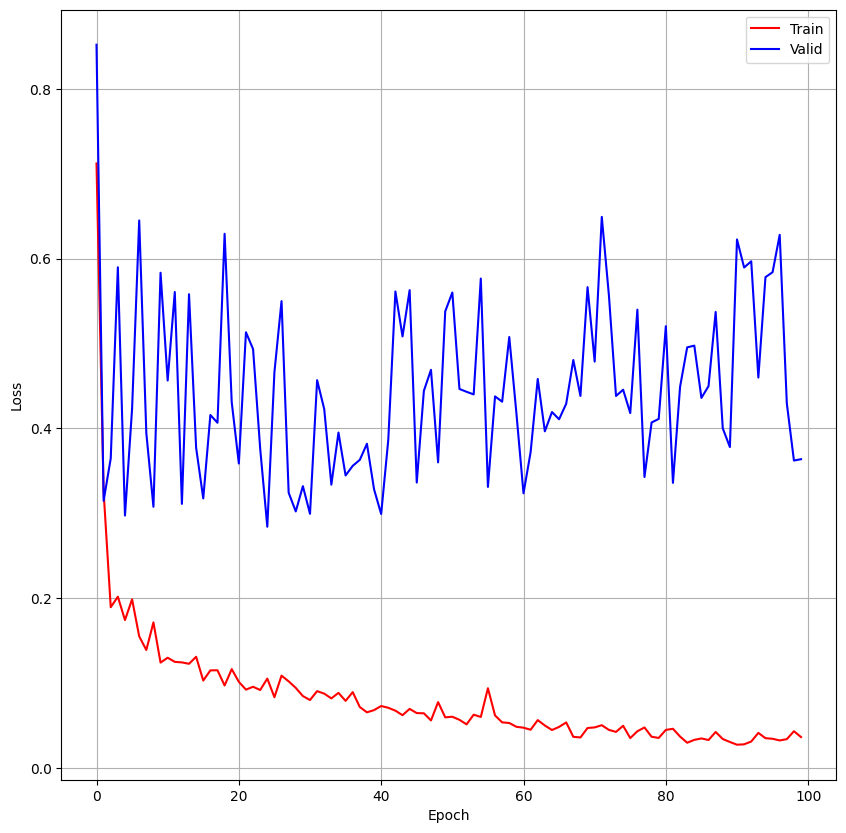

In [28]:
plot_compares(epochs=epochs,
              values1=hist_loss_train,
              label1='Train',
              values2=hist_loss_valid,
              label2='Valid',
              x_label='Epoch',
              y_label='Loss')

#### Plot (Accuracy)

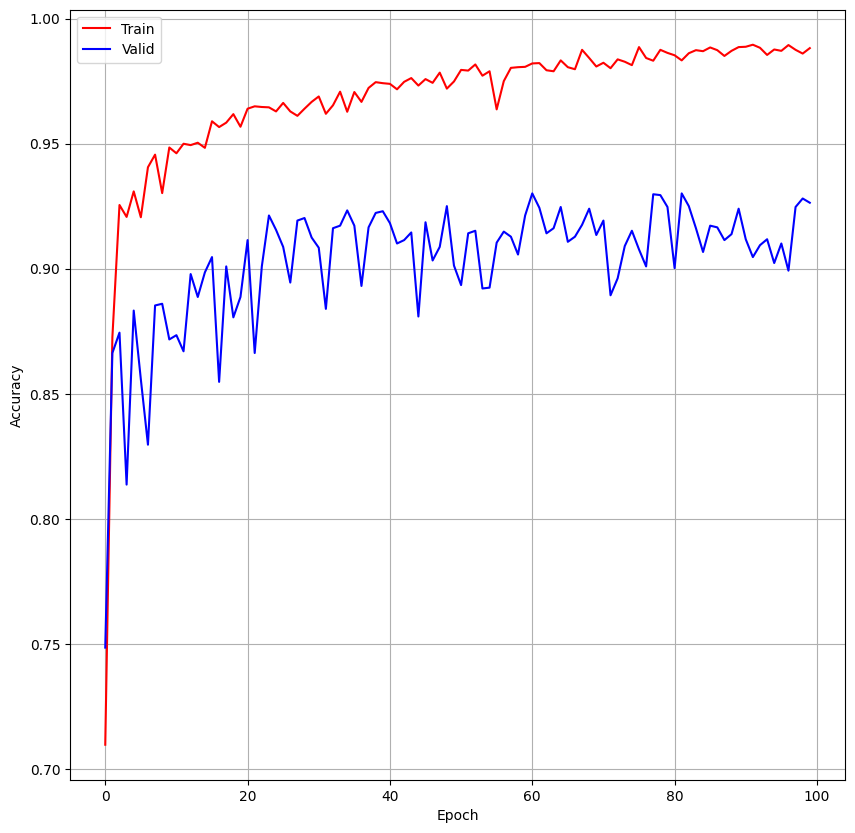

In [29]:
plot_compares(epochs=epochs,
              values1=hist_acc_train,
              label1='Train',
              values2=hist_acc_valid,
              label2='Valid',
              x_label='Epoch',
              y_label='Accuracy')

#### Plot (F1 Score)

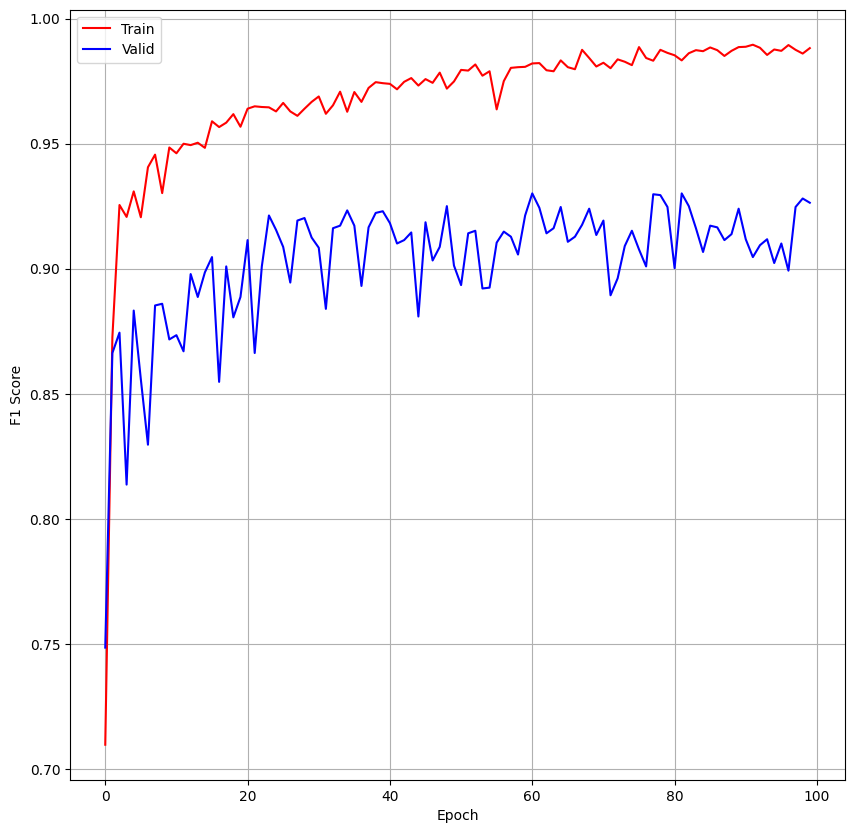

In [30]:
plot_compares(epochs=epochs,
              values1=hist_f1_train,
              label1='Train',
              values2=hist_f1_valid,
              label2='Valid',
              x_label='Epoch',
              y_label='F1 Score')

---
#### Save Model

In [ ]:
!mkdir save

In [31]:
torch.save(torch.tensor(hist_acc_train), f'./save/{model_name}_{optim_name}_acc_train.pt')
torch.save(torch.tensor(hist_acc_valid), f'./save/{model_name}_{optim_name}_acc_valid.pt')

torch.save(torch.tensor(hist_loss_train), f'./save/{model_name}_{optim_name}_loss_train.pt')
torch.save(torch.tensor(hist_loss_valid), f'./save/{model_name}_{optim_name}_loss_valid.pt')

---
#### Comparing

In [34]:
def plot_lcs(x: str = 'loss' or 'acc', y: str = 'train' or 'valid'):
    """
    Plot the tables.
    :param x: choose from 'loss' or 'acc'
    :param y: choose from 'train' or 'valid'
    :return: plot the models.
    """

    plt.figure(figsize=(8, 6))
    for name in ['RNN', 'LSTM', 'Transformer']:
        z = torch.load(f'./save/{name}_{optim_name}_{x}_{y}.pt')
        plt.plot(range(epochs), z, label=name)
        plt.xlabel('Epoch')
        plt.ylabel(f'{x}-{y}')
        plt.grid(True)
        plt.legend()

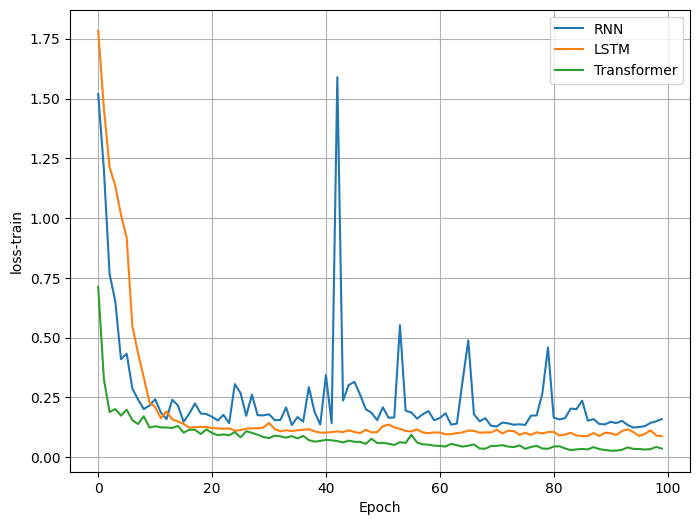

In [35]:
plot_lcs(x='loss', y='train')

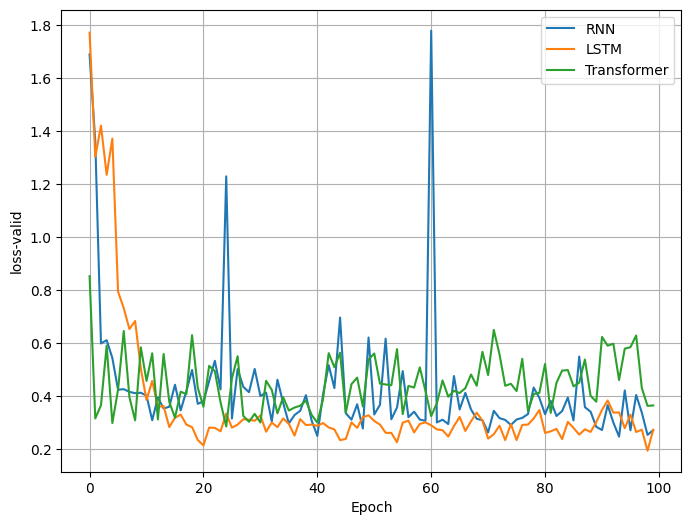

In [36]:
plot_lcs(x='loss', y='valid')

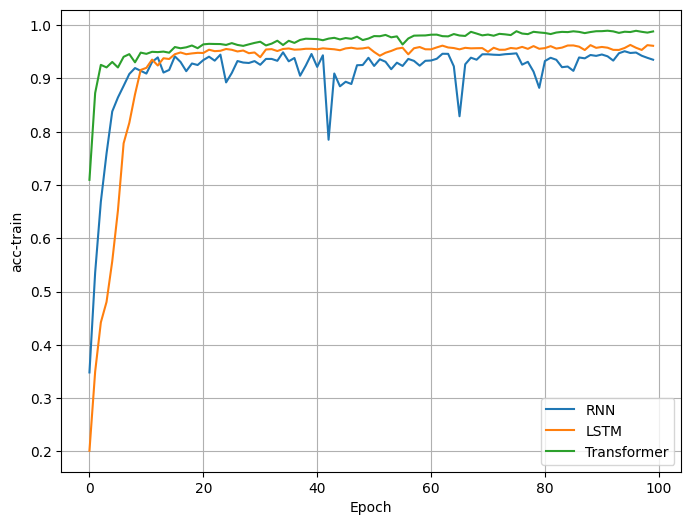

In [37]:
plot_lcs(x='acc', y='train')

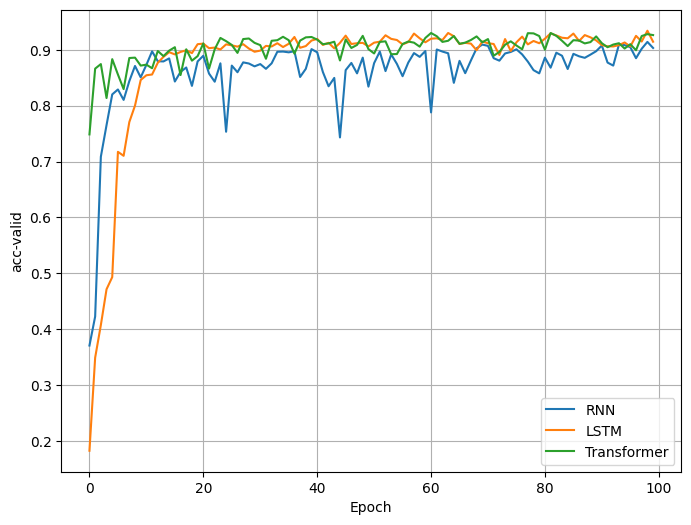

In [38]:
plot_lcs(x='acc', y='valid')